In [1]:
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np

In [2]:
from collections import defaultdict
import heapq

In [3]:
IMAGE_URL = "slider_puffin_before_mobile.jpg"

In [4]:
#extracting RGB colors from image
def RGBimage(url):
    img = np.asarray(Image.open(url))
    return img
img = RGBimage(IMAGE_URL)
img.shape

(800, 800, 3)

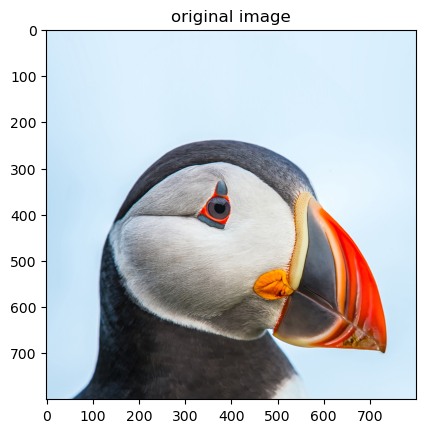

In [5]:
plt.title("original image")
plt.imshow(img)

In [6]:
#this function will made a tranfer of rgb mode to ycbcr mode in images.
def rgb2ycbcr(img):
    
    ycbcr = np.zeros_like(img)
    
    # extractin r, g, b from originl image.
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    #transfer from RGB to YCbCr
    y = 0.2557*r + 0.502*g + 0.0976*b + 16
    cb = (112*b - 37.797*r -74.203*g ) * 1/256 + 128
    cr = (112*r - 93.786*g - 18.214*b) * 1/256 + 128
    
    # Combine the YCbCr components into a single numpy array for reasmbling new image.
    ycbcr[:,:,0] = y
    ycbcr[:,:,1] = cb
    ycbcr[:,:,2] = cr
    
    plt.title("YCbCr format image")
    plt.imshow(ycbcr)
    return ycbcr

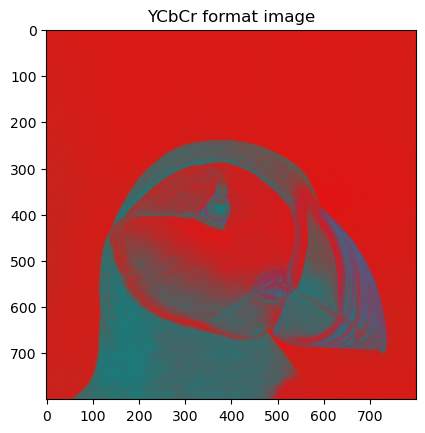

In [7]:
ycbcr_img = rgb2ycbcr(img)

In [8]:
""" implementing matrix factorization for DCT """
def image_block_factorization(image):

    height, width , _ = image.shape
    # Split the image into 8x8 blocks by using image dimentions and sliding 8*8 blocked on possible areas
    blocks = [image[i:i+8, j:j+8] for i in range(0, height, 8) for j in range(0, width, 8)]
    
    return blocks
    

In [9]:
blocks = image_block_factorization(ycbcr_img)

In [10]:
import math

"""Compute the  Discrete Cosine Transform(DCT) of the input block."""
def dct_2d(block):

    N = block.shape[0]
    #for sumation area
    cosin_transform = [[math.cos((2*i+1)*j * math.pi/16) for j in range(8)] for i in range(8)]
    sum = 0
    result = np.arange(64*3).reshape(8,8,3)
    for u in range(N):
        sum = 0
        for v in range(N):
            for i in range(N):
                   for j in range(N):
                        sum += block[i][j] * cosin_transform[i][u] * cosin_transform[j][v]
            #C(u,v) -> 0: 1/sqrt(2) o.w: 1
            if u == 0 : sum*= math.sqrt(1/2)
            if v == 0 : sum*= math.sqrt(1/2)
            sum*= math.sqrt(1/(N*N))
            result[u,v] = sum
     
    return result

In [11]:
# Apply DCT to each block
dct1D = []
#passing blockes to function for implementing compution of DCT for block
for i, block in enumerate(blocks):
    dct1D.append(dct_2d(block))

In [12]:
# Apply DCT to each block
dct1D_temp = []
#passing blockes to function for implementing compution of DCT for block
for i, block in enumerate(blocks):
    dct1D_temp.append(dct_2d(block))

In [13]:
# Compute the frequency of each DCT coefficient across all blocks one by one
def hufman_tree_builder(block):
    
    #we will go through chanels for their coefs frequency
    coeff_freq = defaultdict(int)
    for block in dct1D:
        for chanel in block:
              for coeffs in chanel:
                    for coeff in coeffs:
                        coeff_freq[coeff] += 1

    # Build a Huffman tree based on the coefficient frequencies
    heap = [[freq, [coeff, ""]] for coeff, freq in coeff_freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Convert the Huffman tree to a dictionary
    huffman_dict = dict(heapq.heappop(heap)[1:])
    return huffman_dict

In [14]:
dct1D = dct1D_temp
huffman_blockes_code = hufman_tree_builder(dct1D)#seve hufman for each block
huffman_blockes_code

{-5: '000000',
 117: '000001000000',
 -82: '000001000001000',
 -81: '000001000001001',
 -63: '000001000001010',
 171: '000001000001011',
 139: '0000010000011',
 114: '000001000010',
 189: '00000100001100',
 208: '00000100001101',
 211: '00000100001110',
 223: '00000100001111',
 232: '00000100010000',
 289: '000001000100010',
 398: '000001000100011',
 303: '00000100010010',
 324: '00000100010011',
 341: '00000100010100',
 346: '00000100010101',
 362: '00000100010110',
 363: '00000100010111',
 382: '00000100011000',
 439: '00000100011001',
 453: '00000100011010',
 457: '00000100011011',
 468: '00000100011100',
 795: '00000100011101',
 421: '0000010001111',
 -24: '00000100100',
 -23: '00000100101',
 841: '0000010011000',
 873: '000001001100100',
 874: '000001001100101',
 145: '00000100110011',
 -37: '0000010011010',
 63: '0000010011011',
 215: '00000100111000',
 236: '00000100111001',
 255: '00000100111010',
 257: '00000100111011',
 308: '00000100111100',
 325: '00000100111101',
 339: '00

In [15]:
"""  
    implement quantization of DCT coefficients with a pre-defined quantization matrix!
    arguments -> 
            dct_coefficients: coefficients that we alredy found from blockes
            quantization_matrix: statix marix
    here we have boundary selection with round in np and it will be an integer number in return 
    because its quantization and it has to be int!
"""
def quantize_dct_coefficients(dct_coefficients, quantization_matrix):
    
    quantized_coefficients = np.round(dct_coefficients / quantization_matrix)
    return quantized_coefficients.astype(int)

In [16]:
random_matrix = np.random.randint(low=0, high=256, size=(8, 8, 3))

In [17]:
quantized_coefficients = quantize_dct_coefficients(dct1D, random_matrix)
quantized_coefficients[0]

array([[[ 7,  1,  0],
        [12,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],


In [18]:
"""  
    implement hufman encoding system, encode a set of quantized coefficients using the given Huffman tree
    arguments -> 
            huffman_tree: made based on DCT coefficients
            quantized_coefficients: we recieved them from quantize_dct_coefficients
"""

def huffman_encode_coefficients(quantized_coefficients, huffman_tree):
    #the encod binary string
    encoded_coefficients = ''
    for row in quantized_coefficients:
        for chanel in row:
            for coeffs in chanel:
                for coeff in coeffs:
                    #find the related huffman code in tree for single string merging.
                    encoded_coefficients += huffman_tree[coeff]
    return encoded_coefficients

In [19]:
encoded_coefficients = huffman_encode_coefficients(quantized_coefficients, huffman_blockes_code)
encoded_coefficients

'000101011110001000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010101101111000100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101010110111100010001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101011011110001000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010101101111000100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

In [20]:
"""decode a string of binary-encoded coefficients using the given Huffman tree"""
def huffman_decode_coefficients(encoded_coefficients, huffman_tree):
    decoded_coefficients = []
    current_code = ""
    #proccessing over recieved binary stream
    for bit in encoded_coefficients:
        current_code += bit
        for coeff, code in huffman_tree.items():
            #its match with one code of tree, so we can build it again.
            if code == current_code:
                decoded_coefficients.append(coeff)
                current_code = ""
                break
    return np.array(decoded_coefficients)

In [21]:
decoded_coefficients = huffman_decode_coefficients(encoded_coefficients, huffman_blockes_code)
print(decoded_coefficients)

[7 1 0 ... 0 0 0]


In [22]:
""" inverse quantize the coefficients using the given quantization matrix """ 
def dequantize_coefficients(quantized_coefficients, quantization_matrix):
    dequantized_coefficients = quantized_coefficients * quantization_matrix
    return dequantized_coefficients

In [23]:
dequantized_coefficients = dequantize_coefficients(quantized_coefficients, random_matrix)

In [24]:
"""compute the inverse discrete cosine transform (IDCT) of the input block""" 
def idct_2d(block):
    N = block.shape[0]
    #for sumation area
    cosin_transform = [[math.cos((2*i+1)*j * math.pi/16) for j in range(8)] for i in range(8)]
    sum = 0
    result = np.zeros((8,8,3))
    for i in range(N):
        for j in range(N):
            for u in range(N):
                for v in range(N):
                    #C(u,v) -> 0: 1/sqrt(2) o.w: 1
                    cu = math.sqrt(1/2) if u == 0 else 1
                    cv = math.sqrt(1/2) if v == 0 else 1

                    sum += cu * cv * block[u][v] * cosin_transform[i][u] * cosin_transform[j][v]
            sum *= math.sqrt(2/N) if (i == 0 and j == 0) else math.sqrt(2/N) * math.sqrt(2)
            result[i,j] = sum

    return result

In [25]:
blockes_reconstructed = []
for block in dequantized_coefficients:
    blockes_reconstructed.append(idct_2d(block))
blockes_reconstructed

[array([[[222.71671722,  45.        ,   0.        ],
         [467.07813903,  95.45941546,   0.        ],
         [629.9353798 , 131.13961031,   0.        ],
         [732.11556232, 156.36931804,   0.        ],
         [790.32135909, 174.20941546,   0.        ],
         [818.5017959 , 186.82426933,   0.        ],
         [828.49599621, 195.74431804,   0.        ],
         [830.18759897, 202.05174497,   0.        ]],
 
        [[902.00028294, 206.51176933,   0.        ],
         [947.4041547 , 209.66548279,   0.        ],
         [969.57716266, 211.89549497,   0.        ],
         [972.27857015, 213.4723517 ,   0.        ],
         [960.14225053, 214.58735779,   0.        ],
         [938.58329982, 215.37578616,   0.        ],
         [913.40644193, 215.9332892 ,   0.        ],
         [890.22835093, 216.32750339,   0.        ]],
 
        [[944.4555058 , 216.60625491,   0.        ],
         [977.42453068, 216.803362  ,   0.        ],
         [990.80477409, 216.94273776,   

In [26]:
# apply IDCT to each block and combine the resulting blocks to form the reconstructed image
def reconstruct_image(blocks, height, width):
    reconstructed_blocks = []
    for block in blocks:
        reconstructed_block = idct_2d(block)
        reconstructed_blocks.append(reconstructed_block)
    
    reconstructed_image = np.zeros((height, width, 3))
    for i, block in enumerate(reconstructed_blocks):
        row = (i // (width // 8)) * 8
        col = (i % (width // 8)) * 8
        reconstructed_image[row:row+8, col:col+8] = block
    
    return reconstructed_image

In [29]:
reconstructed_image = reconstruct_image(blockes_reconstructed , 800 , 800)

C:\Users\abt\AppData\Local\Temp\ipykernel_12372\3157189984.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = reconstructed_image.astype(np.float)


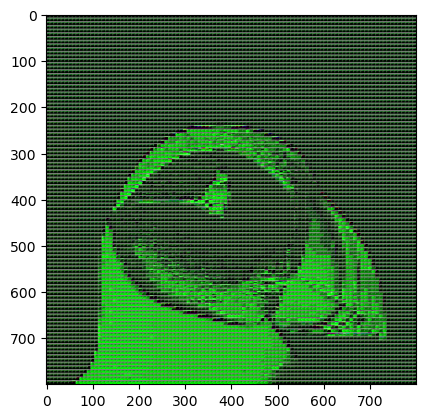

In [30]:
# Convert the YCbCr image to RGB
xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
rgb = reconstructed_image.astype(np.float)
rgb[:,:,[1,2]] -= 128
rgb = rgb.dot(xform.T)
np.putmask(rgb, rgb > 255, 255)
np.putmask(rgb, rgb < 0, 0)
final_image = np.uint8(rgb)

# Display the RGB image
plt.imshow(final_image)

In [ ]:
""" this function will implement an adaptive  huffman enncoding system""""
def huffman_adaptive_encoding(symbol_counts, notebook):
    heap = [[count, [symbol, ""]] for symbol, count in symbol_counts.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        for pair in left[1:]:
            pair[1] = '0' + pair[1]
        for pair in right[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [left[0] + right[0]] + left[1:] + right[1:])
    huffman_dict = dict(sorted(heap[0][1:], key=lambda x: (len(x[-1]), x)))
    encoded = ""
    for symbol in notebook:
        encoded += huffman_dict[symbol]
    return encoded, huffman_dict

# Multiple Quantization Matrixs

In [40]:
def multiple_quantixation_matrinx(low,high):
    random_matrix = np.random.randint(low=low, high=high, size=(8, 8, 3))
    random_matrix= np.abs(random_matrix)
    quantized_coefficients = quantize_dct_coefficients(dct1D, random_matrix)
    encoded_coefficients = huffman_encode_coefficients(quantized_coefficients, huffman_blockes_code)
    decoded_coefficients = huffman_decode_coefficients(encoded_coefficients, huffman_blockes_code)
    dequantized_coefficients = dequantize_coefficients(quantized_coefficients, random_matrix)
    blockes_reconstructed = []
    for block in dequantized_coefficients:
        blockes_reconstructed.append(idct_2d(block))
    blockes_reconstructed
    reconstructed_image = reconstruct_image(blockes_reconstructed , 800 , 800)
    # Convert the YCbCr image to RGB
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = reconstructed_image.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    final_image = np.uint8(rgb)

    # Display the RGB image
    plt.imshow(final_image)

C:\Users\abt\AppData\Local\Temp\ipykernel_12372\2643236512.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = reconstructed_image.astype(np.float)


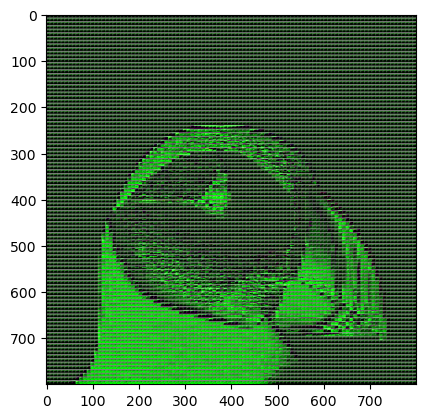

In [41]:
multiple_quantixation_matrinx(1,20)

C:\Users\abt\AppData\Local\Temp\ipykernel_12372\2643236512.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = reconstructed_image.astype(np.float)


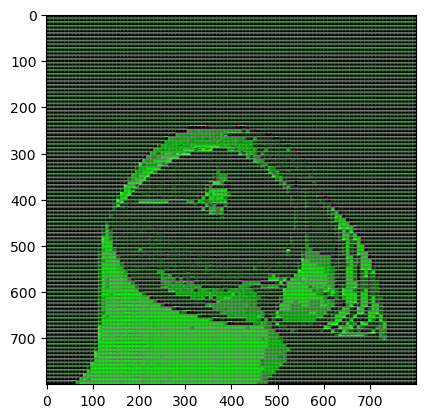

In [42]:
multiple_quantixation_matrinx(1,300)

In [ ]:
multiple_quantixation_matrinx(1,9)

# RGB to HSV

In [47]:
def rgb2HSV(img):
    hsv = np.zeros_like(img)
    
    # extractin r, g, b from originl image.
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            print(r[i,j])
                maxrgb = max(r[i,j], b[i,j], g[i,g])
                minrgb = min(r[i,j], b[i,j], g[i,g])
                c = maxrgb - minrgb
                hsv[i,j,0] = maxrgb
                if c == 0:  h[i,j,1] = 0
                else:
                    if maxrgb == r[i,j]:
                        hsv[i,j,1] = (((g-b)/c)%6)*60
                    elif maxrgb == g[i,j]:
                        hsv[i,j,1] =(((b-r)/c)+2)*60
                    else:
                        hsv[i,j,1] = (((r-g)/c)+4)*60
                
                if hsv[i,j,0] != 0:
                    hsv[i,j,2] = c/hsv[i,j,0]
    
   
    return hsv

In [48]:
hsv = rgb2HSV(img)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed